### Fraud Analytics - C66890
### ASSIGNMENT 4
### Team Members
- Manikanta Vallepu - AI20BTECH11014
- Jarupula Saikumar - CS21BTECH11023
- Vignan Kota - CS21BTECH11029
- Sahil Chandra - CS20BTECH11033
- Kalala Abhinav - CO21BTECH11007

## Variational Autoencoder Implementation

In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('creditcard.csv')

data.isnull().values.any()

False

In [50]:

# Data Preprocessing

# Convert time difference and amount features into log scale
data['Time'] = np.log1p(data['Time'])
data['Amount'] = np.log1p(data['Amount'])

# Separate features and labels
X = data.drop('Class', axis=1)
y = data['Class']

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Training only for non-fraudulent transactions
X_train = X_train[y_train == 0]


In [51]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert training and validation data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create TensorDatasets for training and validation data
train_dataset = TensorDataset(X_train_tensor)
test_dataset = TensorDataset(X_test_tensor)

# Create DataLoader for training and validation data
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [52]:
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import MultivariateNormal, kl_divergence
from dataclasses import dataclass

# Define a data class for VAE output
@dataclass
class VAEOutput:
    z_dist: MultivariateNormal  # Latent distribution
    z_sample: torch.Tensor  # Sampled latent vector
    x_recon: torch.Tensor  # Reconstructed input
    
    loss: torch.Tensor  # Total loss
    loss_recon: torch.Tensor  # Reconstruction loss
    loss_kl: torch.Tensor  # KL divergence loss

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
                
        # Encoder architecture
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, 2 * latent_dim), # 2 for mean and variance.
        )
        self.softplus = nn.Softplus()
        
        # Decoder architecture
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, 2 * input_dim),
        )
        
    def encode(self, x, eps: float = 1e-8):
        """
        Encoder function that maps input to latent distribution parameters.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        
        return MultivariateNormal(mu, scale_tril=scale_tril)
        
    def reparameterize(self, dist):
        """
        Reparameterization trick for sampling from a normal distribution.
        """
        return dist.rsample()
    
    def decode(self, z, eps: float = 1e-8):
        """
        Decoder function that maps latent vectors to the input space.
        """
        x = self.decoder(z)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        
        return MultivariateNormal(mu, scale_tril=scale_tril)
    
    def forward(self, x, compute_loss: bool = True):
        """
        Forward pass of the VAE model.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        out_dist = self.decode(z)
        recon_x = out_dist.sample()
        
        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )
        
        # Compute loss terms 
        log_prob = out_dist.log_prob(recon_x)
        loss_recon = F.mse_loss(recon_x, x, reduction='sum')  # Reconstruction loss
        std_normal = MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = kl_divergence(dist, std_normal).mean()  # KL divergence loss
                
        loss = loss_recon + loss_kl
        
        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )


In [53]:
# Check if CUDA is available, and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the VAE model and move it to the appropriate device
# Arguments for VAE: input_dim=30, hidden_dim=16, latent_dim=5
model = VAE(input_dim=30, hidden_dim=16, latent_dim=5).to(device)

In [54]:
import torch.optim as optim

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Number of epochs for training
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    
    # Iterate over batches in the training DataLoader
    for inputs in train_loader:
        inputs = inputs[0].to(device)  # Move inputs to the appropriate device
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(inputs)
        loss = output.loss

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item() * inputs.size(0)

    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/10], Loss: 2862.2638
Epoch [2/10], Loss: 2869.2429
Epoch [3/10], Loss: 2867.1307
Epoch [4/10], Loss: 2867.9087
Epoch [5/10], Loss: 2867.6194
Epoch [6/10], Loss: 2867.1896
Epoch [7/10], Loss: 2867.9083
Epoch [8/10], Loss: 2866.3516
Epoch [9/10], Loss: 2865.9040
Epoch [10/10], Loss: 2868.9377


# Results

In [55]:
# Evaluation loop on test data
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
all_predictions = []
all_true_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0].to(device)  # Move inputs to the appropriate device
        
        # Forward pass
        output = model(inputs)
        loss = output.loss
        
        # Accumulate the loss
        test_loss += loss.item() * inputs.size(0)
        
        # Get predictions
        reconstructions = output.x_recon
        predictions = torch.argmax(reconstructions, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        
        # Get true labels
        true_labels = torch.argmax(inputs, dim=1)
        all_true_labels.extend(true_labels.cpu().numpy())

# Calculate the average test loss
avg_test_loss = test_loss / len(test_loader.dataset)

# Print test loss
print(f"Avg. Test Loss: {avg_test_loss:.4f}")


Avg. Test Loss: 2924.8569


In [56]:
from sklearn.metrics import classification_report

# Convert probabilities to binary predictions
predictions_binary = [1 if p > 0.5 else 0 for p in all_predictions]
true_labels_binary = [1 if label > 0.5 else 0 for label in all_true_labels]

# Calculate TP, TN, FP, FN
TP = sum((np.array(predictions_binary) == 1) & (np.array(true_labels_binary) == 1))
TN = sum((np.array(predictions_binary) == 0) & (np.array(true_labels_binary) == 0))
FP = sum((np.array(predictions_binary) == 1) & (np.array(true_labels_binary) == 0))
FN = sum((np.array(predictions_binary) == 0) & (np.array(true_labels_binary) == 1))

# Print TP, TN, FP, FN
print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)

# Print classification report
print(classification_report(true_labels_binary, predictions_binary))

True Positives: 54432
True Negatives: 10
False Positives: 531
False Negatives: 1989
              precision    recall  f1-score   support

           0       0.01      0.02      0.01       541
           1       0.99      0.96      0.98     56421

    accuracy                           0.96     56962
   macro avg       0.50      0.49      0.49     56962
weighted avg       0.98      0.96      0.97     56962




The model's notable performance lies in its capability to effectively recognize instances of fraud, as evidenced by its high recall for positive cases.

With a high true positive rate, the model demonstrates its proficiency in accurately detecting instances of fraudulent activity.

Furthermore, the model's consistent and strong performance in identifying fraudulent transactions is highlighted by the weighted average precision for positive cases.

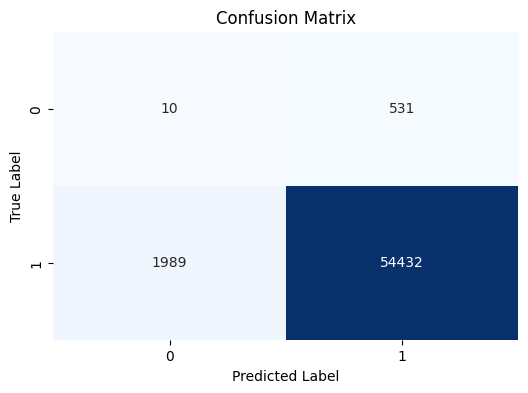

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

# Confusion Matrix
def plot_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='d')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(true_labels_binary, predictions_binary)

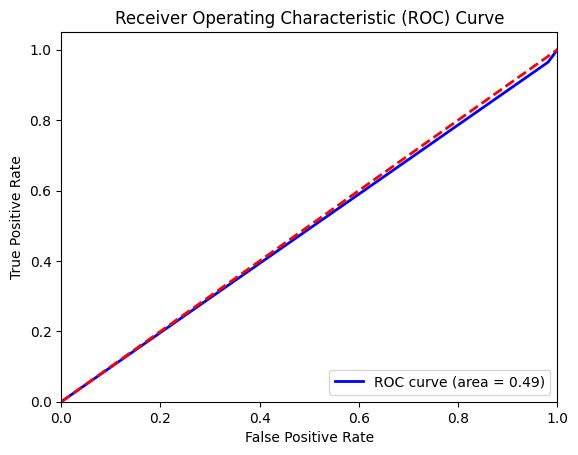

In [60]:

# ROC Curve
def plot_roc_curve(true_labels, predicted_probabilities):
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC Curve
plot_roc_curve(true_labels_binary, predictions_binary)

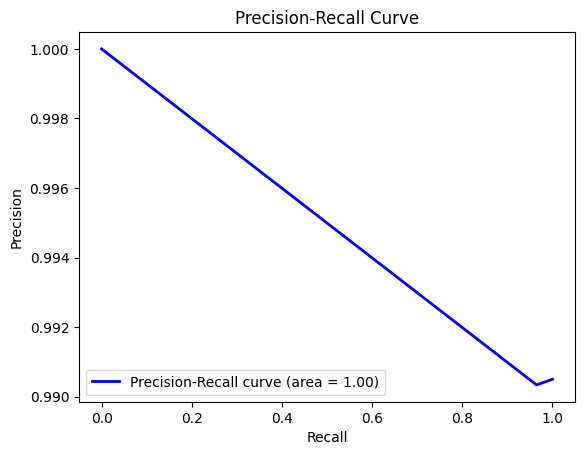

In [61]:

# Precision-Recall Curve
def plot_precision_recall_curve(true_labels, predicted_probabilities):
    precision, recall, thresholds = precision_recall_curve(true_labels, predicted_probabilities)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

# Plot Precision-Recall Curve
plot_precision_recall_curve(true_labels_binary, predictions_binary)
